# StyleSense ML Pipeline Project
- Data, available under "data" subfolder here, is used to create a machine learning model pipeline.

### Aim: Build a ML pipeline to predict whether an item is recommended by a customer based on their review. 

###### Note the data includes numerical, categorical, and text data. Use the data to properly train and evaluate the model under this project.

#### The Data Explained
The dataset has been anonymized and cleaned of missing values.

There are 8 features available to use to predict whether a customer recommends or does not recommend a product. The **Recommended IND** column gives whether a customer recommends the product where 1 is recommended and a 0 is not recommended. This is the target for the model. 

The features in the dataset can be summarized as the following:

- **Clothing ID**: Integer Categorical variable that refers to the specific piece being reviewed.
- **Age**: Positive Integer variable of the reviewers age.
- **Title**: String variable for the title of the review.
- **Review Text**: String variable for the review body.
- **Positive Feedback Count**: Positive Integer documenting the number of other customers who found this review positive.
- **Division Name**: Categorical name of the product high level division.
- **Department Name**: Categorical name of the product department name.
- **Class Name**: Categorical name of the product class name.

#### The target:

**Recommended IND**: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.

#### Sec-1. All Imports Data set loading goes here

In [305]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score


nltk.download(['punkt', 'wordnet','stopwords','punkt_tab'])


[nltk_data] Downloading package punkt to /home/pcbinwal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/pcbinwal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/pcbinwal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/pcbinwal/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [306]:
# Load data
data = pd.read_csv(
    'data/reviews.csv',
)

print(data.info())
display(data.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18442 entries, 0 to 18441
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              18442 non-null  int64 
 1   Age                      18442 non-null  int64 
 2   Title                    18442 non-null  object
 3   Review Text              18442 non-null  object
 4   Positive Feedback Count  18442 non-null  int64 
 5   Division Name            18442 non-null  object
 6   Department Name          18442 non-null  object
 7   Class Name               18442 non-null  object
 8   Recommended IND          18442 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.3+ MB
None


,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name,Recommended IND
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses,0
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants,1


##### Aligning the data to make it ready for model 

In [307]:
### Separation of Features(X) and Target (Y) from the dataset
X = data.drop('Recommended IND', axis=1)
y = data['Recommended IND'].copy()

print('Target Labels:', y.unique())
print('Features:', X.columns)
# X = X.drop("Clothing ID",axis=1,inplace=True)

Target Labels: [0 1]
Features: Index(['Clothing ID', 'Age', 'Title', 'Review Text', 'Positive Feedback Count',
       'Division Name', 'Department Name', 'Class Name'],
      dtype='object')


##### Train Test split of dataset using "train_test_split" API from "sklearn.model_selection"

In [308]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size=0.20,
    shuffle=True,
    random_state=42,
)
print(f"Train: {X_train.shape},{y_train.shape}\t Test: {X_test.shape},{y_test.shape}")

Train: (14753, 8),(14753,)	 Test: (3689, 8),(3689,)


#### Sec-2: Data Exploration (EDA)

In [309]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18442 entries, 0 to 18441
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              18442 non-null  int64 
 1   Age                      18442 non-null  int64 
 2   Title                    18442 non-null  object
 3   Review Text              18442 non-null  object
 4   Positive Feedback Count  18442 non-null  int64 
 5   Division Name            18442 non-null  object
 6   Department Name          18442 non-null  object
 7   Class Name               18442 non-null  object
dtypes: int64(3), object(5)
memory usage: 1.1+ MB


In [310]:
X["Review Text"]

0        I had such high hopes for this dress and reall...
1        I love, love, love this jumpsuit. it's fun, fl...
2        This shirt is very flattering to all due to th...
3        I love tracy reese dresses, but this one is no...
4        I aded this in my basket at hte last mintue to...
                               ...                        
18437    I was very happy to snag this dress at such a ...
18438    It reminds me of maternity clothes. soft, stre...
18439    This fit well, but the top was very see throug...
18440    I bought this dress for a wedding i have this ...
18441    This dress in a lovely platinum is feminine an...
Name: Review Text, Length: 18442, dtype: object

In [311]:
### Separating num, cat and text features 
# Separate numeric and categorical features
num_X = X.select_dtypes(include="int64").columns.tolist()
cat_X = X.select_dtypes(exclude=np.number).columns.tolist()
cat_X.remove('Review Text')
text_X = 'Review Text'
for gname, gval in zip(["Num","Cat","Text"],[num_X,cat_X,text_X]):
    print(gname, gval)


Num ['Clothing ID', 'Age', 'Positive Feedback Count']
Cat ['Title', 'Division Name', 'Department Name', 'Class Name']
Text Review Text


In [312]:
X.describe(percentiles=[0.5, 0.6, 0.7, 0.9, 0.95])

,Clothing ID,Age,Positive Feedback Count
count,18442.000000,18442.000000,18442.000000
mean,954.896757,43.383635,2.697484
std,141.571783,12.246264,5.942220
min,2.000000,18.000000,0.000000
50%,952.000000,41.000000,1.000000
60%,1030.000000,45.000000,1.000000
70%,1074.000000,49.000000,2.000000
90%,1094.000000,61.000000,7.000000
95%,1107.000000,66.000000,12.000000
max,1205.000000,99.000000,122.000000


##### Data has following properties: 
```
X: 
- Three Numeric fields (Int)
    - One ID field (Int) 
- Four Categorical Fields  
Y: 
- Binary class with 
    - 1: Recommended 
    - 0: Not recommended
```
##### None of trhe feature contains null values.

- Histogram tell that both numeric fields has left squeezed distribution. 
- Age indicates more mean value of 41 with 70% less than 50 years of age.
- Average Positive feedbacks are single ... though max feedback count is 122 but 95th percentime also have just 12 feedbacks. Beyond 95 percentile numbers are outliers. 

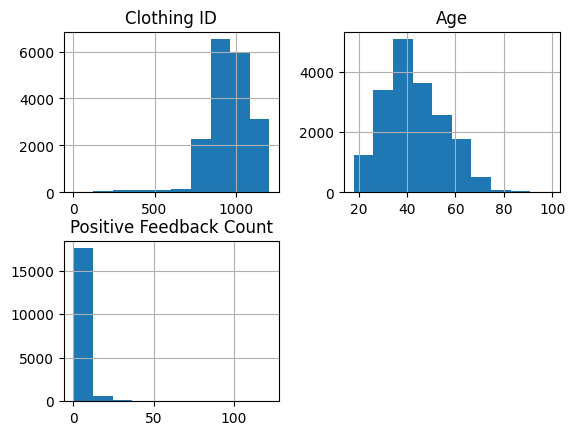

In [313]:
X.hist();

##### Target(y):
Target value is unbalances: 82% Recommended and 18% not recommended. 


In [314]:
y.value_counts()/y.count()

Recommended IND
1    0.816235
0    0.183765
Name: count, dtype: float64

In [315]:
data[['Age', 'Positive Feedback Count',"Recommended IND"]].corr()

,Age,Positive Feedback Count,Recommended IND
Age,1.000000,0.039429,0.036656
Positive Feedback Count,0.039429,1.000000,-0.058392
Recommended IND,0.036656,-0.058392,1.000000


In [316]:
data.duplicated().sum()

np.int64(0)

##### Other Explorations
- There is no significant correlation among numerical features and the target
- There are no duplicates in the data


### Sec-3: Crafting the ML Pipeline
- Handling Num datatype
- Handling Cat datatype
- Handling the review_text field

In [317]:
class NLTKPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Initialize NLTK tools
        self.lemmatizer = WordNetLemmatizer()
        self.stopwords = list(stopwords.words('english'))

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self._preprocess(text) for text in X]

    def _preprocess(self, text):
        # Lowercase the text
        text = text.lower()
        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Tokenize
        tokens = word_tokenize(text)
        # Remove stopwords and lemmatize
        processed_tokens = [
            self.lemmatizer.lemmatize(token)
            for token in tokens
            if token not in self.stopwords
        ]
        # Join tokens back into a string
        return ' '.join(processed_tokens)

# def get_tokenize(ptext):
#     """
#     Function to tokenize text given as input string.
#     Following actions are taken: 
#     - tokenize
#     - filter for stop words and non english words
#     - lemmatize (Instead of stemming)
#     """
    
#     tokens = word_tokenize(ptext.lower())
#     stop_words = set(stopwords.words('english'))
#     filtered = [w for w in tokens if w.isalpha() and w not in stop_words]

#     lemmatizer = WordNetLemmatizer()
    
#     clean_tokens=[]
#     for tok in filtered:
#         clean_tok = lemmatizer.lemmatize(tok).lower().strip()
#         clean_tokens.append(clean_tok)
    
#     tokenized_string = ' '.join(clean_tokens)

#     return tokenized_string


In [318]:
# Create preprocessing pipelines for each datatype 
numerical_transformer = Pipeline([('scaler', MinMaxScaler())])
categorical_transformer = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore'))])
# For text data, use TF-IDF vectorizer
# text_transformer = Pipeline([('tfidf', TfidfVectorizer())])
text_transformer = Pipeline([
    # ('nltk_preprocessor', NLTKPreprocessor()),
    ('tfidf_vectorizer', TfidfVectorizer())
])

# Combine three column transformations defined for Num, Cat and Text   
preprocessor = ColumnTransformer([
        ('num', numerical_transformer, num_X),
        ('cat', categorical_transformer, cat_X),
        ('text', text_transformer, text_X)
    ])

## Creating Final Pipeline combining Preprocessing and modelling
# The pipeline will first preprocess the data and then fit the model
# Using Naive Bayes classifier, which works well with TF-IDF features
final_model_1 = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', MultinomialNB())])

final_model_2 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
    ])

final_model_3 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=25, random_state=42))
    ])
final_model_4 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42))
    ])


### Sec-4: Model Validation and Observations

In [319]:
print(f"Baseline Accuracy was: {y[y==1].count()/y.count()*100:.2f}%")

def fit_validate(name,final_model):
    print(f"Model-->{name}")
    # Train the model
    final_model.fit(X_train, y_train)

    # Make predictions on the train set
    y_pred_train = final_model.predict(X_train)

    # Make predictions on the test set
    y_pred_test = final_model.predict(X_test)

    # Evaluate the model using metrics "accuracy_score"
    for act, pred, name in zip([y_train,y_test],[y_pred_train,y_pred_test],["Train","Test"]):
        accuracy = accuracy_score(act, pred)
        precision = precision_score(act, pred)
        recall = recall_score(act,pred)
        print(f"\t{name} Dataset:\tModel Accuracy: {accuracy*100:.2f}% (Precison:{precision*100:.2f}% Recall:{recall*100:.2f}%)")
    
fit_validate("Naive Bayes", final_model_1)
fit_validate("Logistic Regression", final_model_2)
fit_validate("RandomForest", final_model_3)
fit_validate("GradientBoosting", final_model_4)

Baseline Accuracy was: 81.62%
Model-->Naive Bayes
	Train Dataset:	Model Accuracy: 83.42% (Precison:83.13% Recall:100.00%)
	Test Dataset:	Model Accuracy: 81.73% (Precison:81.64% Recall:100.00%)
Model-->Logistic Regression
	Train Dataset:	Model Accuracy: 94.53% (Precison:94.59% Recall:98.97%)
	Test Dataset:	Model Accuracy: 88.56% (Precison:90.22% Recall:96.36%)
Model-->RandomForest
	Train Dataset:	Model Accuracy: 99.86% (Precison:99.83% Recall:100.00%)
	Test Dataset:	Model Accuracy: 82.98% (Precison:83.02% Recall:99.37%)
Model-->GradientBoosting
	Train Dataset:	Model Accuracy: 87.98% (Precison:87.91% Recall:98.89%)
	Test Dataset:	Model Accuracy: 85.52% (Precison:86.51% Recall:97.36%)


Observations: 
- Multinomial Naive Bayes: Model worked well no evident overfitting 
- Logistic Regression: Model has improved accuracy but was overfilling by ~6%
- Random Forest: Again this Model also was overfitting hugely 
- **GradientBoosting: This model gave good results, improved performance and  overfilling down to ~2.5%** 

### Sec-5: Model finetuning and Observations

In [320]:
#### Fine tuning Model Pipeline

def fine_tune(model, param_grid):
    '''
    This function will take model and param_grid as input
    Use GridSeaerchCV to get the best parameters and best estimator.
    Returns the best_estimator object. 
    '''
    # Create a GridSearchCV object
    grid_search = GridSearchCV(
        estimator=model,        # The pipeline to tune
        param_grid=param_grid,  # The parameter grid
        cv=3,                   # Number of cross-validation folds
        n_jobs=-1,              # Use all available CPU cores
        scoring='accuracy',     # Evaluation metric
        verbose=1               # Provides progress updates
    )

# Fit GridSearchCV to the training data
    grid_search.fit(X_train, y_train)
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

    # Use the best model to make predictions on the test set
    return grid_search.best_estimator_


In [323]:
select_model=["MultinomialNB", final_model_1,
    {
    'classifier__alpha': [0.01, 0.1, 0.5, 1.0, 10.0]
}
]

fit_validate(select_model[0], select_model[1])
print("Fine Tunning .............")
fit_validate(select_model[0]+" (Finetuned)",fine_tune(select_model[1],select_model[2]))


Model-->MultinomialNB
	Train Dataset:	Model Accuracy: 83.42% (Precison:83.13% Recall:100.00%)
	Test Dataset:	Model Accuracy: 81.73% (Precison:81.64% Recall:100.00%)
Fine Tunning .............
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters: {'classifier__alpha': 0.01}
Best cross-validation score: 0.8699
Model-->MultinomialNB (Finetuned)
	Train Dataset:	Model Accuracy: 99.11% (Precison:99.72% Recall:99.19%)
	Test Dataset:	Model Accuracy: 86.93% (Precison:88.16% Recall:96.93%)


In [321]:
select_model=["LogisticRegression", final_model_2,
    {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
}
]

fit_validate(select_model[0], select_model[1])
print("Fine Tunning .............")
fit_validate(select_model[0]+" (Finetuned)",fine_tune(select_model[1],select_model[2]))


Model-->LogisticRegression
	Train Dataset:	Model Accuracy: 94.53% (Precison:94.59% Recall:98.97%)
	Test Dataset:	Model Accuracy: 88.56% (Precison:90.22% Recall:96.36%)
Fine Tunning .............
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best cross-validation score: 0.8915
Model-->LogisticRegression (Finetuned)
	Train Dataset:	Model Accuracy: 99.76% (Precison:99.83% Recall:99.88%)
	Test Dataset:	Model Accuracy: 89.29% (Precison:91.51% Recall:95.70%)


In [322]:
select_model=["RandomForest", final_model_3,
    {
    'classifier__n_estimators': [10, 25, 50],
    'classifier__max_depth': [10, 20, None], # None means nodes are expanded until all leaves are pure
    'classifier__min_samples_leaf': [1,3,5],
    # 'classifier__max_features': [1.0]
    # 'classifier__max_features': ['sqrt', 'log2', 1.0]
}
]
fit_validate(select_model[0], select_model[1])
print("Fine Tunning .............")
fit_validate(select_model[0]+" (Finetuned)",fine_tune(select_model[1],select_model[2]))


Model-->RandomForest
	Train Dataset:	Model Accuracy: 99.86% (Precison:99.83% Recall:100.00%)
	Test Dataset:	Model Accuracy: 82.98% (Precison:83.02% Recall:99.37%)
Fine Tunning .............
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 10}
Best cross-validation score: 0.8414
Model-->RandomForest (Finetuned)
	Train Dataset:	Model Accuracy: 99.37% (Precison:99.29% Recall:99.94%)
	Test Dataset:	Model Accuracy: 84.03% (Precison:84.88% Recall:97.76%)


In [324]:
select_model=["GradientBoosting", final_model_4,
    {
    'classifier__n_estimators': [25, 50, 100],
    'classifier__learning_rate': [0.01, 0.2, 0.5],
    'classifier__max_depth': [3, 5, 7]
    }
]

fit_validate(select_model[0], select_model[1])
print("Fine Tunning .............")
fit_validate(select_model[0]+" (Finetuned)",fine_tune(select_model[1],select_model[2]))


Model-->GradientBoosting
	Train Dataset:	Model Accuracy: 87.98% (Precison:87.91% Recall:98.89%)
	Test Dataset:	Model Accuracy: 85.52% (Precison:86.51% Recall:97.36%)
Fine Tunning .............
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__n_estimators': 100}
Best cross-validation score: 0.8685
Model-->GradientBoosting (Finetuned)
	Train Dataset:	Model Accuracy: 94.41% (Precison:94.13% Recall:99.35%)
	Test Dataset:	Model Accuracy: 86.69% (Precison:88.34% Recall:96.33%)


Finetuning Results:
- **MultinomialNB model**, results are improved significantly but overfitting has also increased.  
- **Logistic Regression model**, results were slightly improved, but model is still overfitting by 10%
- **RandomForest model**, results are slightly improved  and still overfitting. 
- **GradientBoosting model**, results significantly improved but now overfitting by 8% 
